In [ ]:
import numpy as np

In [ ]:
def mse(f, g):

    f_arr = np.asarray(f)
    g_arr = np.asarray(g)

    difference = f_arr - g_arr
    
    squared_difference = difference ** 2

    mse = np.mean(squared_difference)
    
    return mse


t = np.linspace(0, 2 * np.pi, 100)

f_signal = np.sin(t)
g_signal_small_diff = np.sin(t + 0.1)
h_signal_large_diff = np.cos(t-np.pi/2)

mse_small = mse(f_signal, g_signal_small_diff)
mse_large = mse(f_signal, h_signal_large_diff)
mse_zero = mse(f_signal, f_signal)

print(f"MSE entre f y g (pequeña diferencia): {mse_small:.6f}")
print(f"MSE entre f y h (gran diferencia): {mse_large:.6f}")
print(f"MSE entre f y f (cero diferencia): {mse_zero:.6f}")



MSE entre f y g (pequeña diferencia): 0.005046
MSE entre f y h (gran diferencia): 0.000000
MSE entre f y f (cero diferencia): 0.000000


ADVERTENCIA: Archivo 'original_sound.wav' no encontrado. Generando señal sinusoidal de prueba.

--- Resultados de Compresión por Submuestreo ---

Factor 1:4 (Tasa: 11025 Hz):
  MSE (Pérdida de Info): 0.006862

Factor 1:8 (Tasa: 5512 Hz):
  MSE (Pérdida de Info): 0.034014

Factor 1:16 (Tasa: 2756 Hz):
  MSE (Pérdida de Info): 0.145258


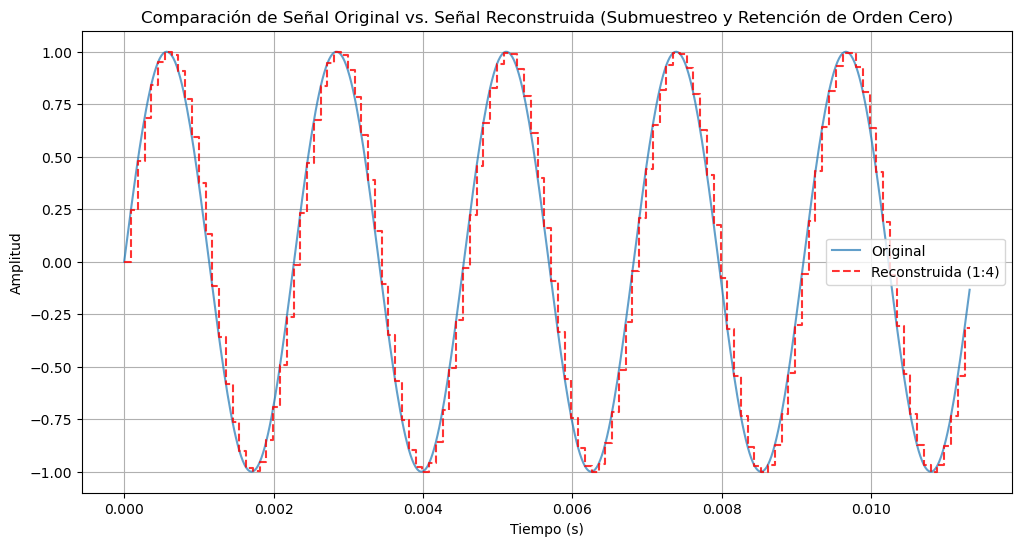

In [9]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

# --- 1. Definición de la Métrica de Distancia (MSE) de la parte a) ---

def quantify_signal_difference_mse(f, g) -> float:
    """Calcula la Diferencia Cuadrática Media (MSE) entre dos señales."""
    # Asegura que las señales tengan la misma longitud para la comparación.
    # Se trunca la señal más larga si es necesario.
    min_len = min(len(f), len(g))
    f_sliced = np.asarray(f[:min_len], dtype=np.float64)
    g_sliced = np.asarray(g[:min_len], dtype=np.float64)
    
    # Normaliza antes de calcular el error para evitar que la magnitud
    # de la señal afecte el resultado de forma desproporcionada.
    if np.max(np.abs(f_sliced)) > 0:
        f_sliced /= np.max(np.abs(f_sliced))
    if np.max(np.abs(g_sliced)) > 0:
        g_sliced /= np.max(np.abs(g_sliced))
        
    difference = f_sliced - g_sliced
    mse = np.mean(difference ** 2)
    return mse

# --- 2. Preparación de la Señal de Sonido Original ---

try:
    # Intenta cargar un archivo WAV (cambia el nombre si es necesario)
    SAMPLE_RATE, original_signal = wavfile.read('original_sound.wav')
    # Si la señal es estéreo, toma solo un canal (el primero)
    if original_signal.ndim > 1:
        original_signal = original_signal[:, 0]
    print(f"Señal de sonido cargada. Tasa de muestreo: {SAMPLE_RATE} Hz, Muestras: {len(original_signal)}")

except FileNotFoundError:
    # Si no se encuentra el archivo, se simula una señal de audio (onda sinusoidal)
    print("ADVERTENCIA: Archivo 'original_sound.wav' no encontrado. Generando señal sinusoidal de prueba.")
    SAMPLE_RATE = 44100  # Frecuencia de muestreo estándar
    duration = 2.0       # Duración en segundos
    t = np.linspace(0, duration, int(SAMPLE_RATE * duration), endpoint=False)
    # Señal de prueba (tono de 440 Hz)
    original_signal = (32767 * np.sin(2 * np.pi * 440 * t)).astype(np.int16)

# Asegurar que la señal original sea de tipo float para cálculos
original_signal_float = original_signal.astype(np.float64)

# --- 3. Submuestreo y Cuantificación de Pérdida de Información ---

# Factores de submuestreo
DOWNSAMPLING_FACTORS = [4, 8, 16]

results = {}

print("\n--- Resultados de Compresión por Submuestreo ---")

for factor in DOWNSAMPLING_FACTORS:
    # COMPRESIÓN (Submuestreo):
    # Simplemente tomar una de cada 'factor' muestras. 
    # Esto reduce la tasa de muestreo a SAMPLE_RATE / factor.
    compressed_signal = original_signal_float[::factor]
    
    # RECONSTRUCCIÓN (Interpolación):
    # Para poder comparar la señal original con la comprimida usando el MSE, 
    # necesitamos que las señales tengan la misma longitud. 
    # Se hace una simple interpolación por repetición del valor submuestreado.
    # ¡Ojo! Este es un método de reconstrucción muy simple, no ideal.
    reconstructed_signal = np.repeat(compressed_signal, factor)
    
    # Asegurarse de que la señal reconstruida no sea más larga que la original
    reconstructed_signal = reconstructed_signal[:len(original_signal_float)]
    
    # CUANTIFICACIÓN de la pérdida de información (Distancia |f-g|):
    mse_loss = quantify_signal_difference_mse(original_signal_float, reconstructed_signal)
    
    results[factor] = {
        'mse': mse_loss,
        'rate': f'{SAMPLE_RATE / factor:.0f} Hz',
        'compression': f'1:{factor}'
    }

    print(f"\nFactor 1:{factor} (Tasa: {results[factor]['rate']}):")
    print(f"  MSE (Pérdida de Info): {mse_loss:.6f}")

# --- 4. Visualización (Opcional) ---

# Tómamos una pequeña porción de la señal para que el gráfico sea visible
N_SAMPLES = 500
time_axis = np.arange(N_SAMPLES) / SAMPLE_RATE

plt.figure(figsize=(12, 6))
plt.plot(time_axis, original_signal_float[:N_SAMPLES], label='Original', alpha=0.7)

# Visualizamos la señal reconstruida con el factor más bajo (1:4)
factor_vis = 4
compressed_vis = original_signal_float[::factor_vis]
reconstructed_vis = np.repeat(compressed_vis, factor_vis)[:N_SAMPLES]

plt.step(time_axis, reconstructed_vis, where='post', label=f'Reconstruida (1:{factor_vis})', linestyle='--', color='red', alpha=0.8)
plt.title('Comparación de Señal Original vs. Señal Reconstruida (Submuestreo y Retención de Orden Cero)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()